In [96]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import scipy 
import statsmodels.api as sm
from statsmodels.stats.meta_analysis import (
    combine_effects
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from matplotlib.gridspec import GridSpec


from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# downloading from kaggle.com/c/sentiment-analysis-on-movie-reviews
# there are two files, train.tsv.zip and test.tsv.zip
# we write to the current directory with './'
api.competition_download_file('titanic',
                              'gender_submission.csv', path='./data/')
api.competition_download_file('titanic',
                              'train.csv', path='./data/')
api.competition_download_file('titanic',
                              'test.csv', path='./data/')

df_train = pd.read_csv('data/train.csv')
X = df_train.drop(['Survived', 'Name', 'PassengerId', "Cabin"], axis = 1)
y = df_train['Survived']

X = X.apply(preprocessing.LabelEncoder().fit_transform)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

#df_test = pd.read_csv('data/test.csv')
#df_test = df_test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis = 1)

tree = DecisionTreeClassifier(max_depth = 5)
fit = tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred, normalize = True))

scores = cross_val_score(tree, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
[[104  10]
 [ 14  51]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       114
           1       0.84      0.78      0.81        65

    accuracy                           0.87       179
   macro avg       0.86      0.85      0.85       179
weighted avg       0.86      0.87      0.86       179

0.8659217877094972
0.81 accuracy with a standard deviation of 0.03


## Decision Tree

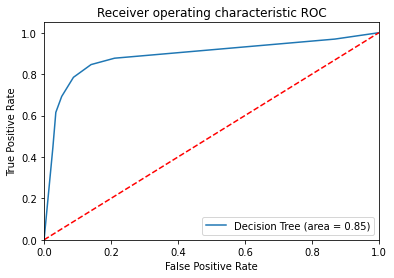

In [97]:
tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")

plt.show()

## Random Forest


In [98]:
rf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators = 100)
rf.fit(X_train, y_train)

rf.predict_proba(X_test)


array([[0.43965607, 0.56034393],
       [0.86599101, 0.13400899],
       [0.50942505, 0.49057495],
       [0.65553268, 0.34446732],
       [0.61626145, 0.38373855],
       [0.8076733 , 0.1923267 ],
       [0.27742609, 0.72257391],
       [0.11625891, 0.88374109],
       [0.45297506, 0.54702494],
       [0.51595095, 0.48404905],
       [0.59345426, 0.40654574],
       [0.58695019, 0.41304981],
       [0.11410282, 0.88589718],
       [0.86349494, 0.13650506],
       [0.1859006 , 0.8140994 ],
       [0.21512133, 0.78487867],
       [0.14003399, 0.85996601],
       [0.6350662 , 0.3649338 ],
       [0.62081823, 0.37918177],
       [0.59540535, 0.40459465],
       [0.5987388 , 0.4012612 ],
       [0.17376461, 0.82623539],
       [0.82739658, 0.17260342],
       [0.79264773, 0.20735227],
       [0.70123632, 0.29876368],
       [0.8261943 , 0.1738057 ],
       [0.85805386, 0.14194614],
       [0.13613623, 0.86386377],
       [0.8489385 , 0.1510615 ],
       [0.82906779, 0.17093221],
       [0.

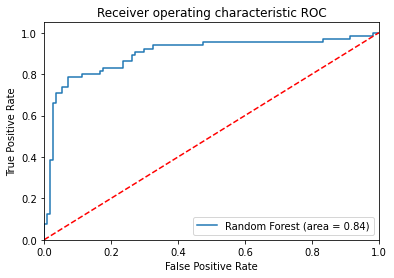

In [99]:
tree_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")

plt.show()

## Logistic Regression



In [100]:
logit_fit = sm.Logit(y_train, X_train).fit()

print(logit_fit.summary())

y_pred = logit_fit.predict(X_test)


Optimization terminated successfully.
         Current function value: 0.466362
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Sun, 24 Jul 2022   Pseudo R-squ.:                  0.3022
Time:                        19:09:38   Log-Likelihood:                -332.05
converged:                       True   LL-Null:                       -475.84
Covariance Type:            nonrobust   LLR p-value:                 2.702e-58
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass         0.2136      0.146      1.464      0.143      -0.072       0.499
Sex           -2.4018      0.

Pclass      1.238103
Sex         0.090551
Age         0.992019
SibSp       0.560168
Parch       0.762412
Ticket      0.999284
Fare        1.015833
Embarked    1.000814
dtype: float64


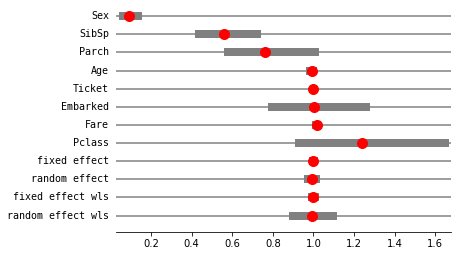

In [101]:
cov = logit_fit.cov_params()
var_effect = np.diag(cov)
mean_effect = logit_fit.params

estimates = pd.concat([pd.DataFrame(mean_effect, columns = ['mean']).reset_index(drop=True),
    pd.DataFrame(var_effect, columns = ['var']).reset_index(drop=True),
    pd.DataFrame(X_train.columns, columns = ['param']).reset_index(drop=True)], axis = 1).sort_values(by=['mean'])

results = combine_effects(estimates['mean'].to_numpy(), estimates['var'].to_numpy(), method_re="chi2", row_names=estimates['param'].to_numpy())
print(np.exp(logit_fit.params))
fig = results.plot_forest(use_exp = True)

## Assessing the results of the logistic regression

* The significant variables from the logistic regression are Sex, SibSp and Age (p < 0.05)
* For Sex: The odds of males surviving as compared to females is approx. 7%.
* For SibSp: Having an additional sibling on the Titanic drops the relative odds of surviving to 54%.
* For Age: A passenger being incrementally 1 year older drops the odds of surviving by about 1%. This translates to approx. 10% for every 10 years of difference in age between passengers.

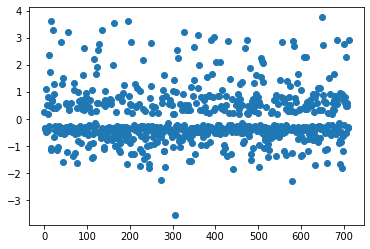

<AxesSubplot:xlabel='Resid', ylabel='Density'>

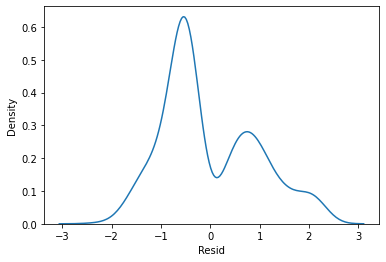

In [102]:
plt.scatter(x = range(0, 712), y = logit_fit.resid_pearson)
plt.show()
sns.kdeplot(data=pd.DataFrame(logit_fit.resid_dev, columns = ['Resid']), x="Resid")

[[99 15]
 [21 44]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       114
           1       0.75      0.68      0.71        65

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179

0.7988826815642458


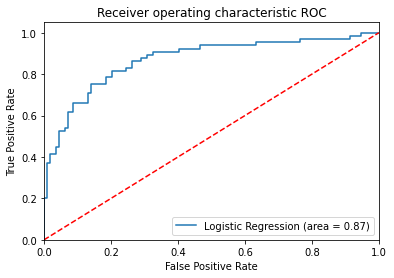

In [103]:
#logit_fit.pred_table(threshold = 0.5)

y_predbin = np.multiply(y_pred > 0.5, 1)
y_predbin

print(confusion_matrix(y_test, y_predbin))
print(classification_report(y_test, y_predbin))
print(accuracy_score(y_test, y_predbin, normalize = True))

logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")

plt.show()

## Assessing Performance

The distribution of residuals should be equally spread out over and under the 0 line, which seems to be the case. 
However, when we look at a density plot, we can see the probabilities are clearly bimodal, suggesting that residuals 

## Kernel Density Plot

In an ideal world, we would like to see a clear seperation between the two density plots, with the deaths being clearly seperated to the left, and the survived population having a clear curve on the right. Although we can see some seperation, there is a large degree of overlap between the density plots. This indicates that that a cut-off for the predicted probability needs to be chosen carefully to maximize model performance (accuracy for e.g).

Although there are no negative predictions or above 1, the KDE plot shows this due to the Gaussian estimator. Hence the graph has been truncated to have only [0,1] as the limits of the x-axis.

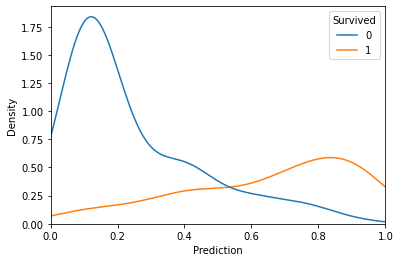

In [104]:
probabilities = pd.DataFrame(y_pred, columns = ['Prediction'])
probabilities = pd.concat([probabilities, pd.DataFrame(y_test, columns = ['Survived']) ], axis = 1)
probabilities.describe()

fig, ax = plt.subplots()
sns.kdeplot(data=probabilities, x="Prediction", hue = "Survived")
ax.set_xlim(0, 1)
plt.show()

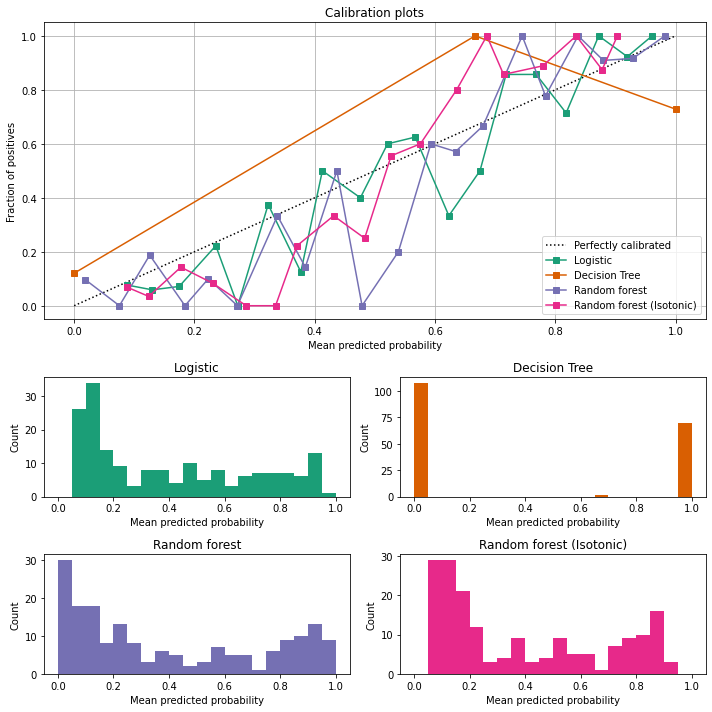

In [106]:
logit = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
calibrated_rf = CalibratedClassifierCV(base_estimator=rf, cv=3)

clf_list = [
    (logit, "Logistic"),
    (dt, "Decision Tree"),
    (rf, "Random forest"),
    (calibrated_rf, "Random forest (Isotonic)"),

]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Calibration Curve comparing Models

<a href="https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py" target="_blank">Source Code</a>

* Decision Tree: This model is very certain and doesn't have any range of predicted probabilities. Predicted probabilities will be either 0 or 1, regardless of the bin being analysed in the calibration curve.
* Logistic Regression: This model is generally overconfident (especially near 0), predicting higher probabilities than the binned set's fraction of positives. However, it follows the diagonal 'perfect' calibration curve better than the other models.
* Random Forest: This model is extremely overconfident for the majority of the graph (0-0.7), consistently predicting higher mean predicted probabilities than the binned set's fraction of positives. Additionally, it deviates quite far from the calibration curve. This indicates that the RF model might need tuning.